# 참고자료
* code reference: https://github.com/cyang-kth/maximum-coverage-location/blob/master/mclp.py
* gis data handling: https://yganalyst.github.io/spatial_analysis/spatial_analysis_2/
* Model.setObjective(): https://www.gurobi.com/documentation/9.1/refman/py_model_setobjective.html
> 기본 목적함수는 선형 및 이차형식이므로 우리만의 가중치를 추가한 새로운 목적함수 정의 필요 
* MCLP modeling: https://minkithub.github.io/2020/10/05/bicgon5/
> 여기는 행정동을 뽑았는데 우리는 행정동은 클러스터링으로 뽑고 행정동 내 입지를 MCLP를 이용해서 골라야 함

In [ ]:
import os, sys 
from google.colab import drive 
drive.mount('/content/mnt') 
nb_path = '/content/notebooks' 
os.symlink('/content/mnt/My Drive/Colab Notebooks', nb_path) 
sys.path.insert(0, nb_path)

Mounted at /content/mnt


In [ ]:
import numpy as np
import pandas as pd
from scipy.spatial import distance_matrix
from gurobipy import *
from scipy.spatial import ConvexHull
#from shapely.geometry import Polygon, Point
from numpy import random

In [ ]:
#df = pd.read_csv('/content/mnt/MyDrive/결과_총점.csv', encoding='cp949')
df = pd.read_csv('/content/mnt/MyDrive/남양주_전처리데이터셋.csv', encoding='cp949')
df = df.iloc[:1000, :]
df.head()

,gid,건물1,건물2,건물3,관공서,전기차,주차장,충전소,변압기,전기안전관리,교통량,경제인구,lon,lat
0,다사73bb67ba,4,2,0,0,0,0,0,0,0,0,202.0,127.203612,37.707828
1,다사85ab65ba,2,0,0,0,0,0,0,0,0,0,0.0,127.334119,37.690057
2,다사82ab57ba,11,0,0,0,0,0,0,0,0,0,0.0,127.300285,37.617897
3,다사70ab68aa,2,0,0,0,0,0,0,0,0,0,0.0,127.163885,37.712228
4,다사86aa66aa,6,0,0,0,0,0,0,0,0,0,0.0,127.342616,37.694575


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7617 entries, 0 to 7616
Data columns (total 14 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   gid     7617 non-null   object 
 1   건물1     7617 non-null   int64  
 2   건물2     7617 non-null   int64  
 3   건물3     7617 non-null   int64  
 4   관공서     7617 non-null   int64  
 5   전기차     7617 non-null   int64  
 6   주차장     7617 non-null   int64  
 7   충전소     7617 non-null   int64  
 8   변압기     7617 non-null   int64  
 9   전기안전관리  7617 non-null   int64  
 10  교통량     7617 non-null   int64  
 11  경제인구    3067 non-null   float64
 12  lon     7617 non-null   float64
 13  lat     7617 non-null   float64
dtypes: float64(3), int64(10), object(1)
memory usage: 833.2+ KB


In [ ]:
def generate_candidate_sites(points,M=100):
    '''
    Generate M candidate sites with the convex hull of a point set
    Input:
        points: a Numpy array with shape of (N,2) -> 반경 안에 있으면 좋은 시설물들의 좌표
        M: the number of candidate sites to generate
    Return:
        sites: a Numpy array with shape of (M,2)
    '''
    # Convex Hull: 2차원 평면상에 여러 개의 점이 있을 때 일부를 이용하여 내부에 모든 점을 포함시키는 다각형 생성 
    hull = ConvexHull(points) 
    polygon_points = points[hull.vertices]
    poly = Polygon(polygon_points)
    min_x, min_y, max_x, max_y = poly.bounds

    # sites: Convex Hull 내부 후보지 선정 -> *랜덤
    sites = []
    while len(sites) < M:
        random_point = Point([random.uniform(min_x, max_x),
                             random.uniform(min_y, max_y)])
        if (random_point.within(poly)):
            sites.append(random_point)

    return np.array([(p.x,p.y) for p in sites])

In [ ]:
x = df.lon
y = df.lat 
df['point'] = df.apply(lambda pt : np.array([pt['lon'], pt['lat']]), axis=1)

In [ ]:
points = []
for pt in df.point:
    points.append(pt) 
  
points = np.array(points)
points.shape

(1000, 2)

In [ ]:
generate_candidate_sites(points, M=100)

array([[127.12553866,  37.70579715],
       [127.31547067,  37.71918161],
       [127.22710533,  37.61765684],
       [127.19319649,  37.69202152],
       [127.25525218,  37.64857698],
       [127.28936779,  37.59201941],
       [127.28276382,  37.66433812],
       [127.20485385,  37.67713644],
       [127.34819182,  37.61735829],
       [127.33854094,  37.64842688],
       [127.15148023,  37.64043405],
       [127.35216417,  37.6629593 ],
       [127.1626282 ,  37.74249434],
       [127.20141506,  37.67545111],
       [127.34221945,  37.68311103],
       [127.35527837,  37.69816303],
       [127.15071635,  37.66198773],
       [127.25497331,  37.70171689],
       [127.37164616,  37.66165974],
       [127.21950241,  37.71788323],
       [127.18802196,  37.71118767],
       [127.26244948,  37.66263526],
       [127.22949871,  37.58768405],
       [127.26591927,  37.62715259],
       [127.22208974,  37.68891101],
       [127.24959956,  37.59832664],
       [127.18136123,  37.67176891],
 

In [ ]:
def mclp(points,K,radius,M):
    """
    Solve maximum covering location problem
    Input:
        points: input points, Numpy array in shape of [N,2]
        K: the number of sites to select
        radius: the radius of circle
        M: the number of candidate sites, which will randomly generated inside
        the ConvexHull wrapped by the polygon
    Return:
        opt_sites: locations K optimal sites, Numpy array in shape of [K,2]
        f: the optimal value of the objective function
    """
    
    print('----- Configurations -----')
    print('  Number of points %g' % points.shape[0])
    print('  K %g' % K)
    print('  Radius %g' % radius)
    print('  M %g' % M)

    import time
    start = time.time()

    sites = generate_candidate_sites(points,M)
    J = sites.shape[0]
    I = points.shape[0]
    D = distance_matrix(points,sites)
    mask1 = D<=radius
    D[mask1]=1
    D[~mask1]=0

    # Build model
    m = Model()

    # Add variables
    x = {}
    y = {}
    for i in range(I):
        y[i] = m.addVar(vtype=GRB.BINARY, name="y%d" % i)
    for j in range(J):
        x[j] = m.addVar(vtype=GRB.BINARY, name="x%d" % j)

    m.update()
    # Add constraints
    m.addConstr(quicksum(x[j] for j in range(J)) == K)

    for i in range(I):
        m.addConstr(quicksum(x[j] for j in np.where(D[i]==1)[0]) >= y[i])
   
    # 목적함수 수정 필요 
    m.setObjective(quicksum(y[i]for i in range(I)),GRB.MAXIMIZE)
    m.setParam('OutputFlag', 0)
    m.optimize()
    end = time.time()
    print('----- Output -----')
    print('  Running time : %s seconds' % float(end-start))
    print('  Optimal coverage points: %g' % m.objVal)
    
    solution = []
    if m.status == GRB.Status.OPTIMAL:
        for v in m.getVars():
            # print v.varName,v.x
            if v.x==1 and v.varName[0]=="x":
                solution.append(int(v.varName[1:]))
    opt_sites = sites[solution]
    return opt_sites,m.objVal

In [ ]:
mclp(points,3, 5,100)

----- Configurations -----
  Number of points 500
  K 3
  Radius 5
  M 100
----- Output -----
  Running time : 0.07685017585754395 seconds
  Optimal coverage points: 500


(array([[127.26055278,  37.67083273],
        [127.30048598,  37.70262797],
        [127.32623536,  37.72683479]]), 500.0)

In [ ]:
opt_sites = mclp(points,3, 5,100)[0]

----- Configurations -----
  Number of points 1000
  K 3
  Radius 5
  M 100
----- Output -----
  Running time : 0.17088007926940918 seconds
  Optimal coverage points: 1000


In [ ]:
def plot_input(points):
    '''
    Plot the result
    Input:
        points: input points, Numpy array in shape of [N,2]
        opt_sites: locations K optimal sites, Numpy array in shape of [K,2]
        radius: the radius of circle
    '''
    from matplotlib import pyplot as plt
    fig = plt.figure(figsize=(8,8))
    plt.scatter(points[:,0],points[:,1],c='C0')
    ax = plt.gca()
    ax.axis('equal')
    ax.tick_params(axis='both',left=False, top=False, right=False,
                       bottom=False, labelleft=False, labeltop=False,
                       labelright=False, labelbottom=False)

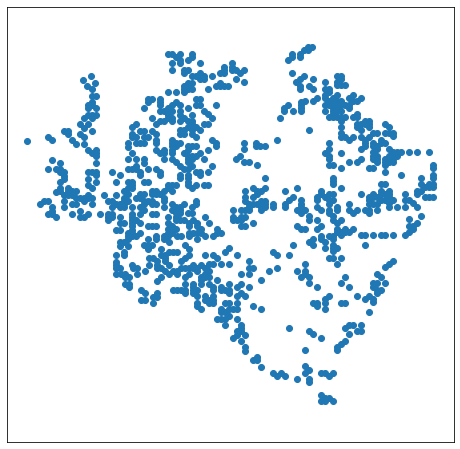

In [ ]:
plot_input(points)

In [ ]:
def plot_result(points,opt_sites,radius):
    '''
    Plot the result
    Input:
        points: input points, Numpy array in shape of [N,2]
        opt_sites: locations K optimal sites, Numpy array in shape of [K,2]
        radius: the radius of circle
    '''
    from matplotlib import pyplot as plt
    fig = plt.figure(figsize=(8,8))
    plt.scatter(points[:,0],points[:,1],c='C0')
    ax = plt.gca()
    plt.scatter(opt_sites[:,0],opt_sites[:,1],c='C1',marker='+')
    for site in opt_sites:
        circle = plt.Circle(site, radius, color='C1',fill=False,lw=2)
        ax.add_artist(circle)
    ax.axis('equal')
    ax.tick_params(axis='both',left=False, top=False, right=False,
                       bottom=False, labelleft=False, labeltop=False,
                       labelright=False, labelbottom=False)

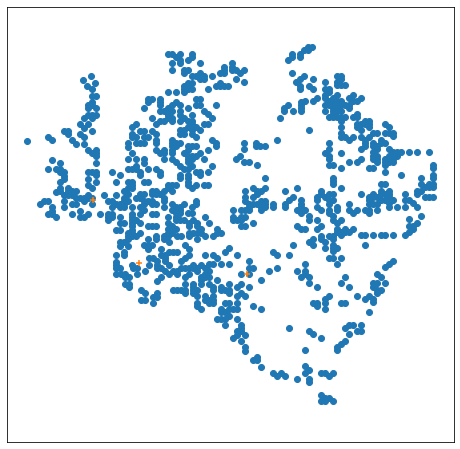

In [ ]:
plot_result(points, opt_sites, 3)

# Example

In [ ]:
from mclp import *
import matplotlib.pyplot as plt
%matplotlib inline

### Generate input data

In [ ]:
import numpy as np
Npoints = 300
# Generate points in uniform distribution 
# points = np.random.rand(Npoints,2)

# Generate points in moon distribution
from sklearn.datasets import make_moons
points,_ = make_moons(Npoints,noise=0.15)

In [ ]:
# Plot input data
plot_input(points)

### Run the optimization

In [ ]:
# Number of sites to select
K = 20

# Service radius of each site
radius = 0.2

# Candidate site size (random sites generated)
M = 100

# Run mclp opt_sites is the location of optimal sites and f is the points covered
opt_sites,f = mclp(points,K,radius,M)

# Plot the result
plot_result(points,opt_sites,radius)

### Run the another configuration

In [ ]:
K = 20
radius = 0.2
M = 10000
opt_sites,f = mclp(points,K,radius,M)
plot_result(points,opt_sites,radius)